# Libraries

In [1]:
import pandas as pd, numpy as np, torch, random
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score,
                             f1_score, roc_auc_score, average_precision_score, ConfusionMatrixDisplay)
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import time

In [3]:
!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00


In [4]:
!pip -q install peft==0.11.1
from peft import LoraConfig, get_peft_model, PeftModel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 12.1 MB/s eta 0:00:00


In [5]:
!pip install wordcloud
from wordcloud import WordCloud

## set seed for reproducibility

In [6]:
SEED = 29
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load local FinancialPhraseBank (AllAgree)

In [8]:
path = "/content/Sentences_AllAgree.txt"
df = pd.read_csv(path, sep='@', names=['sentence','label'], engine='python', encoding='latin1')
df['label'] = df['label'].str.strip()

label_order = ['positive','neutral','negative']
label_map = {lbl:i for i,lbl in enumerate(label_order)}
df['label'] = df['label'].map(label_map)

print(df.head())
print(df['label'].value_counts())

                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      0
2  In the third quarter of 2010 , net sales incre...      0
3  Operating profit rose to EUR 13.1 mn from EUR ...      0
4  Operating profit totalled EUR 21.1 mn , up fro...      0
label
1    1391
0     570
2     303
Name: count, dtype: int64


# EDA

## Word Cloud

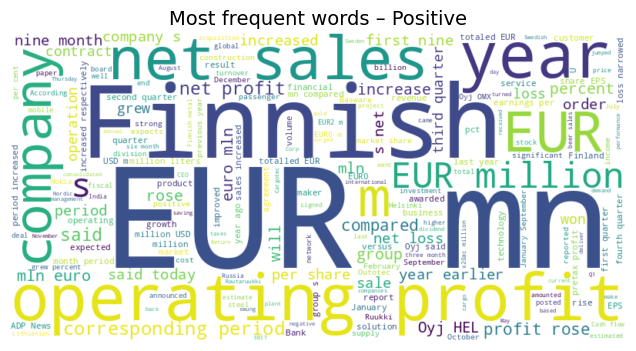

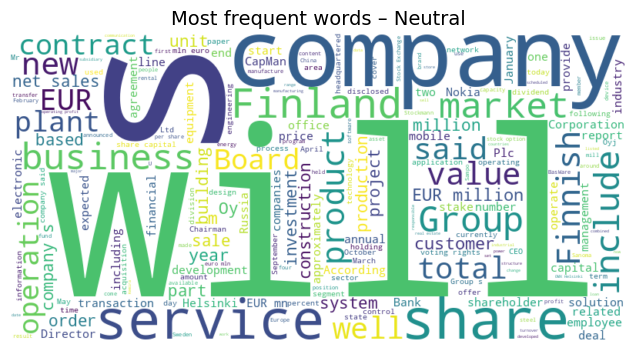

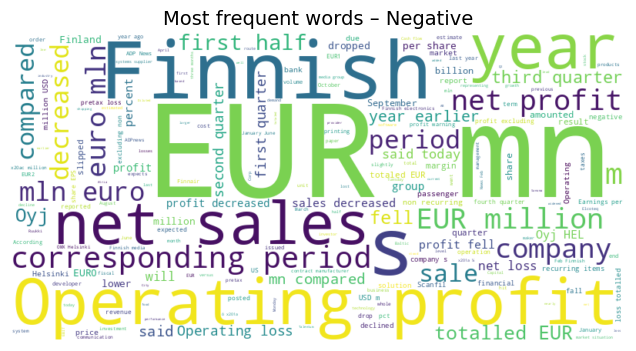

In [ ]:
def plot_wordcloud(sentences, label_name):
    text = " ".join(sentences)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most frequent words – {label_name}", fontsize=14)
    plt.show()

plot_wordcloud(df[df['label']==0]['sentence'], "Positive")
plot_wordcloud(df[df['label']==1]['sentence'], "Neutral")
plot_wordcloud(df[df['label']==2]['sentence'], "Negative")


# Split (80/10/10)

In [21]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})

#Baseline: TF-IDF + Logistic Regression

In [22]:
vec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
Xtr = vec.fit_transform(train_df["sentence"])
Xte = vec.transform(test_df["sentence"])
lr = LogisticRegression(max_iter=200, class_weight="balanced")
lr.fit(Xtr, train_df["label"])
pred = lr.predict(Xte)
print(classification_report(test_df["label"], pred, target_names=label_order, digits=4))

              precision    recall  f1-score   support

    positive     0.8333    0.7895    0.8108        57
     neutral     0.9161    0.9424    0.9291       139
    negative     0.7333    0.7097    0.7213        31

    accuracy                         0.8722       227
   macro avg     0.8276    0.8139    0.8204       227
weighted avg     0.8703    0.8722    0.8710       227



# Tokenisation

In [23]:
MODEL = "ProsusAI/finbert"
tok = AutoTokenizer.from_pretrained(MODEL)

def preprocess(examples):
    return tok(examples["sentence"], truncation=True, padding=False, max_length=128)

to_remove = [c for c in ["sentence", "__index_level_0__"] if c in ds["train"].column_names]
ds_tok = ds.map(preprocess, batched=True, remove_columns=to_remove)

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

# Model + Trainer setup

In [24]:
num_labels = len(label_order)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)

data_collator = DataCollatorWithPadding(tokenizer=tok)
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# Full fine-tuning

In [29]:
args = TrainingArguments(
    output_dir="../runs/finbert_fpb",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=25,
    report_to="none",
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
eval_val = trainer.evaluate()

t0=time.time()
time=time.time()-t0
val = trainer.evaluate()

preds = trainer.predict(ds_tok["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

full_metrics_val = trainer.evaluate()
full_preds = trainer.predict(ds_tok["test"])
full_y_true = preds.label_ids
full_y_pred = preds.predictions.argmax(axis=1)

print("Validation metrics:", eval_val)
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_order, digits=4))

/tmp/ipython-input-3158100083.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.106000,0.098202,0.973451,0.958935
2,0.022700,0.089662,0.982301,0.971380
3,0.022500,0.053425,0.982301,0.973619


Validation metrics: {'eval_loss': 0.053424835205078125, 'eval_accuracy': 0.9823008849557522, 'eval_f1_macro': 0.9736186648505719, 'eval_runtime': 0.8968, 'eval_samples_per_second': 252.003, 'eval_steps_per_second': 8.92, 'epoch': 3.0}

Test Classification Report:
              precision    recall  f1-score   support

    positive     0.9483    0.9649    0.9565        57
     neutral     1.0000    0.9784    0.9891       139
    negative     0.9394    1.0000    0.9688        31

    accuracy                         0.9780       227
   macro avg     0.9626    0.9811    0.9715       227
weighted avg     0.9787    0.9780    0.9781       227



In [ ]:
full_save_dir = "../runs/finbert_fullft_best"
trainer.save_model(full_save_dir)     # saves model weights + config
tok.save_pretrained(full_save_dir)


('../runs/finbert_fullft_best/tokenizer_config.json',
 '../runs/finbert_fullft_best/special_tokens_map.json',
 '../runs/finbert_fullft_best/vocab.txt',
 '../runs/finbert_fullft_best/added_tokens.json',
 '../runs/finbert_fullft_best/tokenizer.json')

# LoRA fine-tuning (PEFT)

In [25]:
MODEL = "ProsusAI/finbert"
num_labels = 3  # positive, neutral, negative
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)

In [26]:
lora_cfg = LoraConfig(
    r=8, # rank
    lora_alpha=16, # scaling
    lora_dropout=0.1, # regularization
    bias="none",
    target_modules=["query", "key", "value", "dense"],
    task_type="SEQ_CLS",
)

lora_model = get_peft_model(base_model, lora_cfg)

def count_trainable(m):
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in m.parameters())
    print(f"Trainable: {trainable:,} / Total: {total:,}  ({100*trainable/total:.2f}% trainable)")

count_trainable(lora_model)

Trainable: 1,341,699 / Total: 110,826,246  (1.21% trainable)


## Trainer for LoRA

In [27]:
lora_args = TrainingArguments(
    output_dir="../runs/finbert_fpb_lora",
    num_train_epochs=3,
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=25,
    report_to="none",
    seed=29,
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics,
)

lora_trainer.train()

lora_val = lora_trainer.evaluate()
lora_preds = lora_trainer.predict(ds_tok["test"])
lora_y_true = lora_preds.label_ids
lora_y_pred = lora_preds.predictions.argmax(axis=1)

/tmp/ipython-input-738740565.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.148600,0.087032,0.973451,0.968031
2,0.077100,0.085353,0.973451,0.963738
3,0.027900,0.076691,0.977876,0.970080


# Comparison, evaluation between Full Fine Tuning and LoRA

In [30]:
print("Full FT (Validation): ", full_metrics_val)
print("Full FT (Test):")
print(classification_report(full_y_true, full_y_pred, target_names=['positive','neutral','negative'], digits=4))

print(f"\nLoRA (Validation): {lora_val}")
print("LoRA (Test): ")
print(classification_report(lora_y_true, lora_y_pred, target_names=['positive','neutral','negative'], digits=4))

summary = {
    "FullFT": {"val_acc": full_metrics_val["eval_accuracy"], "val_f1": full_metrics_val["eval_f1_macro"]},
    "LoRA":   {"val_acc": lora_val["eval_accuracy"],         "val_f1": lora_val["eval_f1_macro"]},
}
summary

Full FT (Validation):  {'eval_loss': 0.053424835205078125, 'eval_accuracy': 0.9823008849557522, 'eval_f1_macro': 0.9736186648505719, 'eval_runtime': 0.8655, 'eval_samples_per_second': 261.131, 'eval_steps_per_second': 9.244, 'epoch': 3.0}
Full FT (Test):
              precision    recall  f1-score   support

    positive     0.9483    0.9649    0.9565        57
     neutral     1.0000    0.9784    0.9891       139
    negative     0.9394    1.0000    0.9688        31

    accuracy                         0.9780       227
   macro avg     0.9626    0.9811    0.9715       227
weighted avg     0.9787    0.9780    0.9781       227


LoRA (Validation): {'eval_loss': 0.07669080048799515, 'eval_accuracy': 0.9778761061946902, 'eval_f1_macro': 0.9700799873287401, 'eval_runtime': 1.0093, 'eval_samples_per_second': 223.908, 'eval_steps_per_second': 7.926, 'epoch': 3.0}
LoRA (Test): 
              precision    recall  f1-score   support

    positive     0.9194    1.0000    0.9580        57
     n

{'FullFT': {'val_acc': 0.9823008849557522, 'val_f1': 0.9736186648505719},
 'LoRA': {'val_acc': 0.9778761061946902, 'val_f1': 0.9700799873287401}}

## Confusion matrix

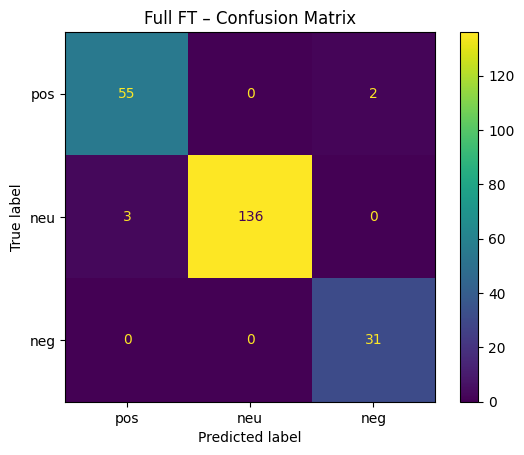

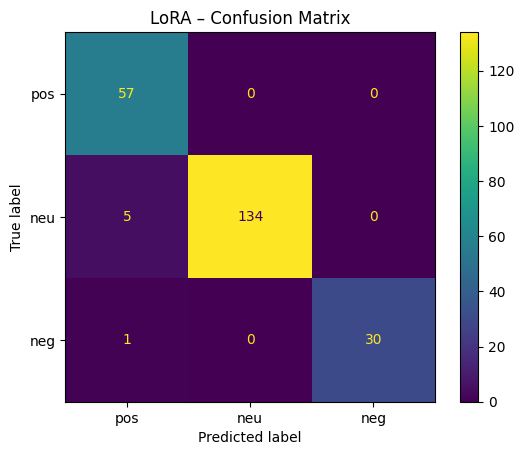

In [ ]:
ConfusionMatrixDisplay.from_predictions(full_y_true, full_y_pred, display_labels=['pos','neu','neg'])
plt.title("Full FT – Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(lora_y_true, lora_y_pred, display_labels=['pos','neu','neg'])
plt.title("LoRA – Confusion Matrix")
plt.show()


## Model Evaluation

In [31]:
# helpers
def softmax_np(logits):
    z = logits - logits.max(axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / exp.sum(axis=1, keepdims=True)

def macro_auc_pr(y_true_int, prob, n_classes):
    """
    y_true_int: shape (n_samples,) integer labels
    prob:      shape (n_samples, n_classes) predicted probabilities
    returns: (macro_roc_auc, macro_pr_auc)
    """
    y_true_ovr = label_binarize(y_true_int, classes=list(range(n_classes)))
    roc = roc_auc_score(y_true_ovr, prob, average='macro', multi_class='ovr')
    pr  = average_precision_score(y_true_ovr, prob, average='macro')
    return roc, pr

y_true_test = test_df['label'].to_numpy()
n_classes = 3

# Baseline
Xte = vec.transform(test_df["sentence"])
base_pred = lr.predict(Xte)
base_prob = lr.predict_proba(Xte)

base_acc  = accuracy_score(y_true_test, base_pred)
base_f1   = f1_score(y_true_test, base_pred, average='macro')
base_roc, base_pr = macro_auc_pr(y_true_test, base_prob, n_classes)

# Full FT (trainer)
full_out   = trainer.predict(ds_tok["test"])
full_logits = full_out.predictions
full_pred   = full_logits.argmax(axis=1)
full_prob  = softmax_np(full_logits)

full_acc  = accuracy_score(y_true_test, full_pred)
full_f1   = f1_score(y_true_test, full_pred, average='macro')
full_roc, full_pr = macro_auc_pr(y_true_test, full_prob, n_classes)

# LoRA
lora_out   = lora_trainer.predict(ds_tok["test"])
lora_logits = lora_out.predictions
lora_pred   = lora_logits.argmax(axis=1)
lora_prob  = softmax_np(lora_logits)

lora_acc  = accuracy_score(y_true_test, lora_pred)
lora_f1   = f1_score(y_true_test, lora_pred, average='macro')
lora_roc, lora_pr = macro_auc_pr(y_true_test, lora_prob, n_classes)

# Summary table
import pandas as pd
summary_df = pd.DataFrame([
    ["TF-IDF + LogisticRegression", base_acc, base_f1, base_roc, base_pr],
    ["FinBERT (Full Fine-Tuning)", full_acc, full_f1, full_roc, full_pr],
    ["FinBERT (LoRA / PEFT)",      lora_acc, lora_f1, lora_roc, lora_pr],
], columns=["Model","Accuracy","Macro-F1","Macro ROC-AUC (OvR)","Macro PR-AUC"])

print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

                      Model  Accuracy  Macro-F1  Macro ROC-AUC (OvR)  Macro PR-AUC
TF-IDF + LogisticRegression    0.8722    0.8204               0.9595        0.9076
 FinBERT (Full Fine-Tuning)    0.9780    0.9715               0.9987        0.9962
      FinBERT (LoRA / PEFT)    0.9780    0.9757               0.9965        0.9852


## Bar chart

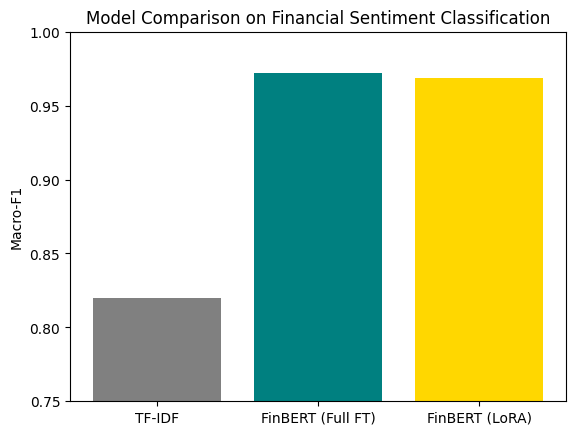

In [ ]:
models = ['TF-IDF', 'FinBERT (Full FT)', 'FinBERT (LoRA)']
f1 = [0.820, 0.972, 0.969]

plt.bar(models, f1, color=['gray','teal','gold'])
plt.ylabel('Macro-F1')
plt.title('Model Comparison on Financial Sentiment Classification')
plt.ylim(0.75, 1.0)
plt.show()

## Efficiency vs. performance visualisation

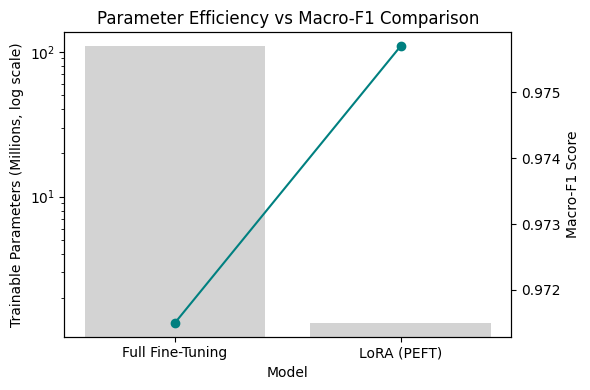

In [33]:
models = ["Full Fine-Tuning", "LoRA (PEFT)"]
params_m = [109.48, 1.34]
f1 = [0.9715, 0.9757]

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(models, params_m, color="lightgray")
ax1.set_yscale('log')
ax1.set_ylabel("Trainable Parameters (Millions, log scale)")
ax1.set_xlabel("Model")

ax2 = ax1.twinx()
ax2.plot(models, f1, color="teal", marker='o', label="Macro-F1")
ax2.set_ylabel("Macro-F1 Score")

plt.title("Parameter Efficiency vs Macro-F1 Comparison")
plt.tight_layout()
plt.show()

## Training Efficiency Comparison

In [ ]:
def count_trainable(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable: {trainable:,} / Total: {total:,}  ({100 * trainable/total:.2f}% trainable)")
    return trainable, total

full_model = AutoModelForSequenceClassification.from_pretrained("../runs/finbert_fullft_best")

# Compare parameter counts
count_trainable(full_model)
count_trainable(lora_model)  # LoRA


Trainable: 109,484,547 / Total: 109,484,547  (100.00% trainable)
Trainable: 1,341,699 / Total: 110,826,246  (1.21% trainable)


(1341699, 110826246)

## Error Analysis

In [ ]:
pred_df = pd.DataFrame({
    "sentence": test_df["sentence"].values,
    "true": [label_order[i] for i in y_true],
    "pred": [label_order[i] for i in y_pred]
})
mis = pred_df[pred_df["true"] != pred_df["pred"]]
mis.sample(5, random_state=29)

,sentence,true,pred
166,3 January 2011 - Scandinavian lenders Sampo Ba...,neutral,positive
221,The mill 's raw material need will increase by...,neutral,positive
90,"In a letter to Economic Affairs Minister , the...",neutral,positive
80,"Profit after taxes was EUR 0.1 mn , compared t...",positive,negative
185,9 September 2010 - Finnish stationery and gift...,positive,negative
